In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
image_size=128
batch_size=16
epochs=10
channels=3


In [4]:
import os

path = r"C:\Users\manoj\Desktop\tomato_disease_prediction\training\PlantVillage"
print(os.path.exists(path))


True


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\manoj\Desktop\tomato_disease_prediction\training\PlantVillage",
    shuffle=True,
    seed=123,
    image_size=(128, 128),
    batch_size=16
)

print(train_ds.class_names)


Found 16011 files belonging to 10 classes.
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [6]:
class_name=train_ds.class_names
class_name

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
len(train_ds)

1001

In [8]:
501*32

16032

In [9]:
for image_batch,label_batch in train_ds.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].numpy())

(16, 128, 128, 3)
[7 2 4 6 5 7 6 5 6 7 4 7 1 1 2 1]
[[[116.   116.   116.  ]
  [112.5  112.5  112.5 ]
  [108.   108.   108.  ]
  ...
  [126.25 130.25 129.25]
  [134.25 138.25 137.25]
  [131.5  135.5  134.5 ]]

 [[118.5  118.5  118.5 ]
  [118.   118.   118.  ]
  [113.25 113.25 113.25]
  ...
  [122.   126.   125.  ]
  [130.5  134.5  133.5 ]
  [128.   132.   131.  ]]

 [[126.   126.   126.  ]
  [123.   123.   123.  ]
  [118.5  118.5  118.5 ]
  ...
  [120.75 124.75 123.75]
  [122.75 126.75 125.75]
  [127.   131.   130.  ]]

 ...

 [[110.75 109.75 104.75]
  [117.   116.   111.  ]
  [118.5  117.5  112.5 ]
  ...
  [129.25 134.25 128.25]
  [126.25 131.25 125.25]
  [126.   131.   125.  ]]

 [[110.   109.   104.  ]
  [115.   114.   109.  ]
  [117.25 116.25 111.25]
  ...
  [127.5  132.5  126.5 ]
  [124.5  129.5  123.5 ]
  [126.5  131.5  125.5 ]]

 [[111.75 110.75 105.75]
  [113.5  112.5  107.5 ]
  [113.   112.   107.  ]
  ...
  [128.   133.   127.  ]
  [125.   130.   124.  ]
  [128.   133.   127.

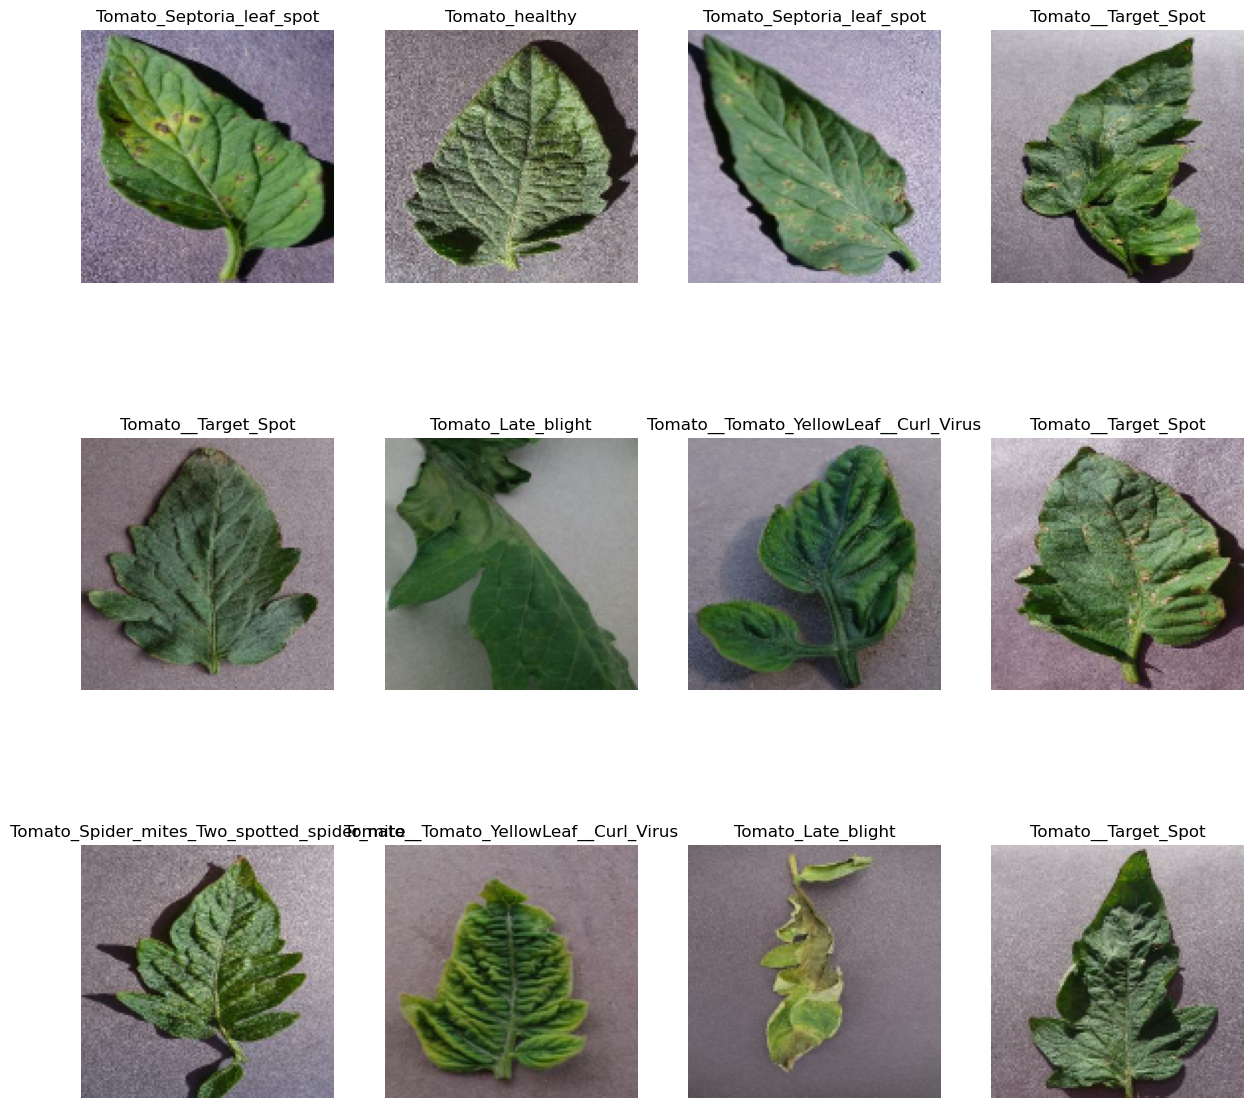

In [10]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [14]:
 length= len(train_ds)
 length

1001

In [15]:
train_size=int(0.8*length)
train_size

800

In [16]:
vali_size=int(0.1*length)
vali_size

100

In [17]:
test_size=train_ds.skip(450)
len(test_size)

551

In [18]:
def get_dataset_partitions_tf(
    ds, 
    train_split=0.8, 
    val_split=0.1, 
    test_split=0.1, 
    shuffle=True, 
    shuffle_size=10000
):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(train_ds)

In [20]:
len(train_ds)


800

In [21]:
len(val_ds)

100

In [22]:
len(test_ds)

101

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (image_size, image_size, channels)
n_classes = 10

model = models.Sequential([
    layers.Input(shape=input_shape),

    
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1./255),

    
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

    layers.Conv2D(32, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(n_classes, activation='softmax')
])


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [27]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [28]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 598s 630ms/step - accuracy: 0.6664 - loss: 0.9742 - val_accuracy: 0.7744 - val_loss: 0.6468
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 398s 498ms/step - accuracy: 0.7977 - loss: 0.5967 - val_accuracy: 0.6488 - val_loss: 1.1756
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 400s 500ms/step - accuracy: 0.8381 - loss: 0.4734 - val_accuracy: 0.6313 - val_loss: 1.1832
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 414s 517ms/step - accuracy: 0.8703 - loss: 0.3860 - val_accuracy: 0.7631 - val_loss: 0.7079
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 398s 498ms/step - accuracy: 0.8808 - loss: 0.3471 - val_accuracy: 0.7344 - val_loss: 0.8751
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 393s 492ms/step - accuracy: 0.8960 - loss: 0.3010 - val_accuracy: 0.5856 - val_loss: 2.2848
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 406s 508ms/step - accuracy: 0.9098 - loss: 0.2728 - val_accuracy: 0.7500 - val_loss: 1.1469
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 6257s 8s/step - accuracy: 0.9143 - l

In [29]:
score=model.evaluate(test_ds)
score

101/101 ━━━━━━━━━━━━━━━━━━━━ 98s 88ms/step - accuracy: 0.8385 - loss: 0.4694


[0.46940314769744873, 0.8384901285171509]

In [30]:
history

In [31]:
history.params


{'verbose': 1, 'epochs': 10, 'steps': 800}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
type(history.history['loss'])


list

In [34]:
len(history.history['loss'])

10

In [35]:
history.history['loss'][:5]

[0.9741607308387756,
 0.5966751575469971,
 0.47336694598197937,
 0.38603660464286804,
 0.34713631868362427]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

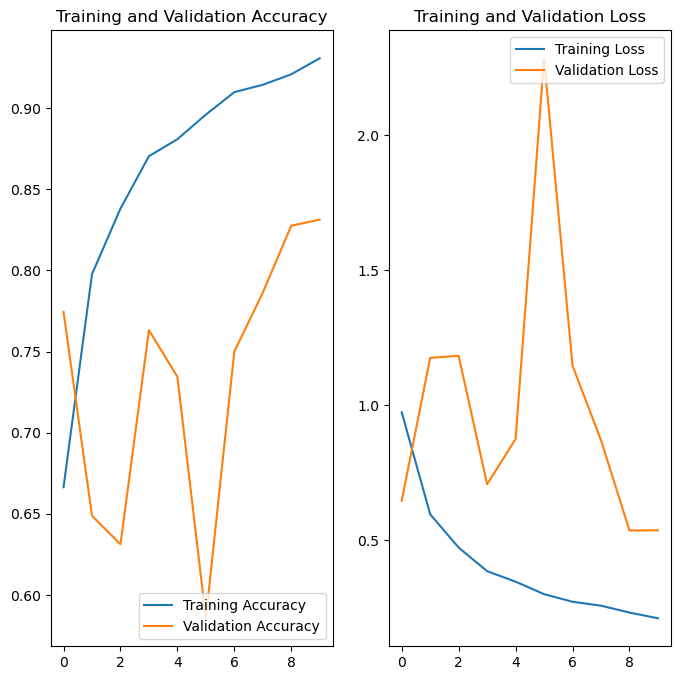

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
predicted label: Tomato_Bacterial_spot


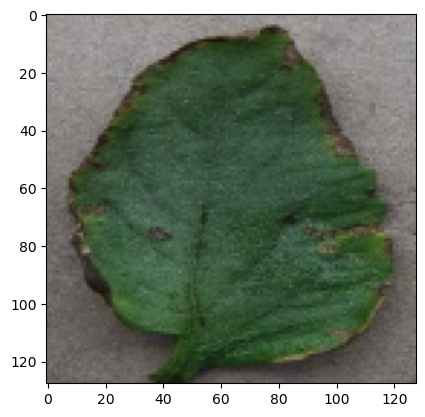

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[1])])

In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


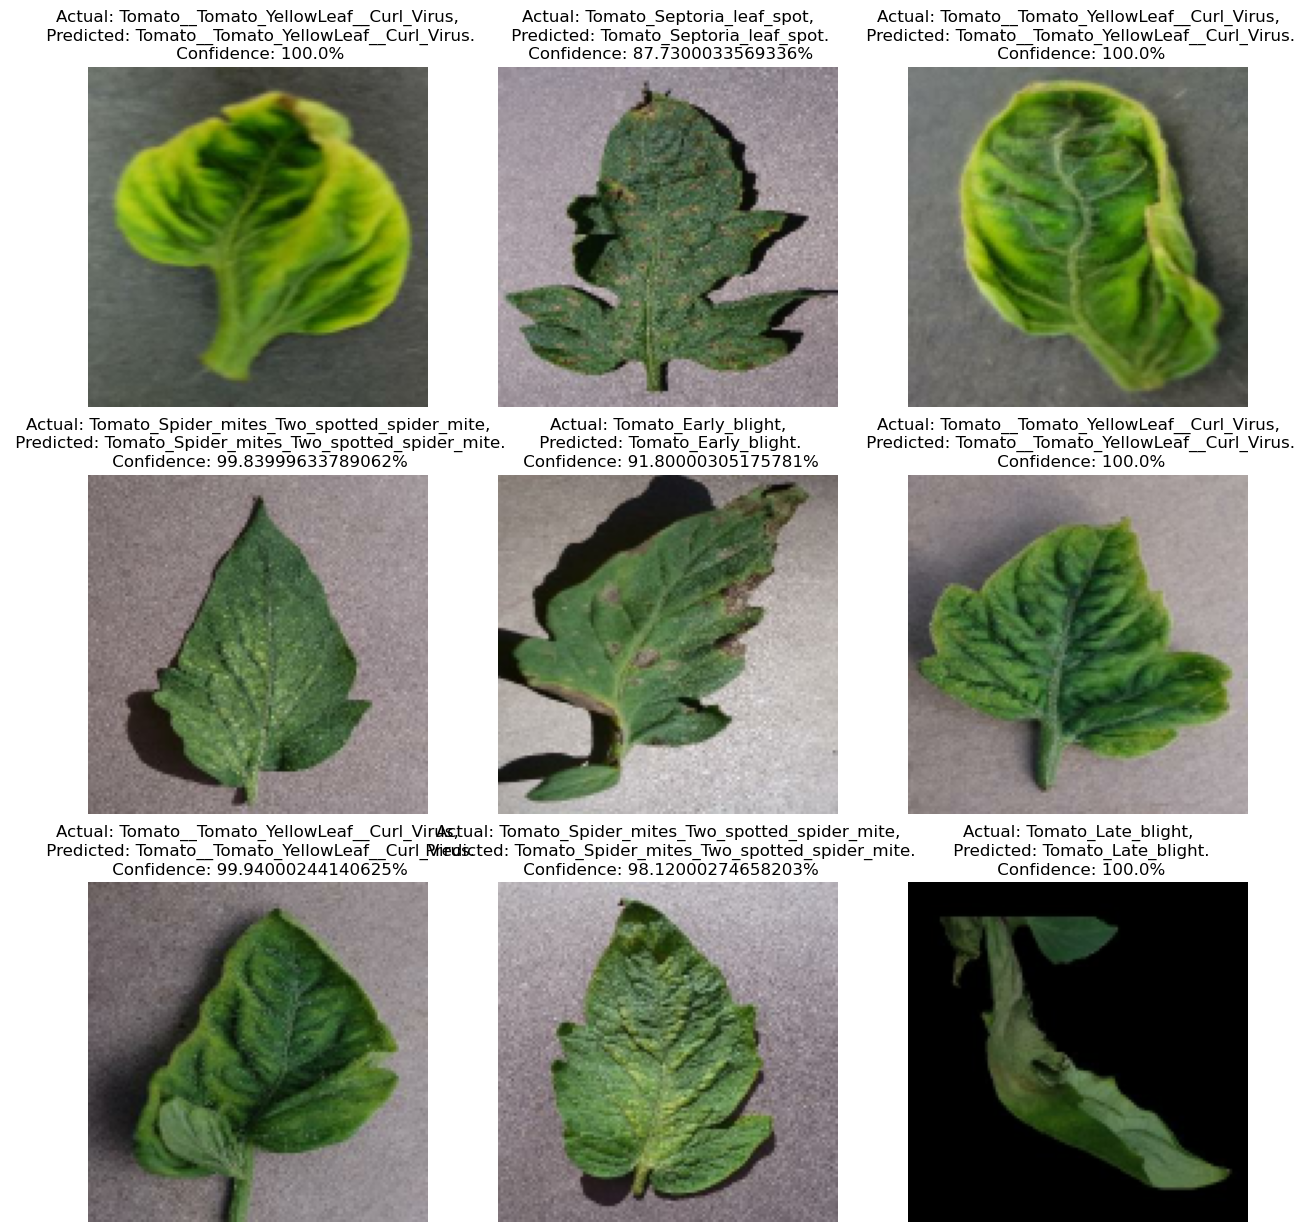

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [58]:
import os

model_version = max([int(i) for i in os.listdir("../model")] + [0]) + 1
model.export(f"../model/{model_version}")


INFO:tensorflow:Assets written to: ../model/3\assets


INFO:tensorflow:Assets written to: ../model/3\assets


Saved artifact at '../model/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2558221962512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558268989584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558269178512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558269181200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558269180624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558269178128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558269180240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558269180432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558269178896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558269183504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558269182928: TensorSpec(shape=(), dty

In [59]:
model.save("../tomatoes.h5")